 # 전통적 시계열 모델링

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성 

* 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

## (3) 데이터 불러오기

In [4]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path, usecols = ['date', 'sales'])
data = data.loc[data['date']<= '2014-10-31'].reset_index(drop = True)
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.day_name().str.slice(0,3)
data.head()

,date,sales,weekday
0,2013-01-01,45,Tue
1,2013-01-02,53,Wed
2,2013-01-03,65,Thu
3,2013-01-04,66,Fri
4,2013-01-05,97,Sat


* 변수 설명

    * date : 날짜
    * sales : 판매량
    * weekday : 요일

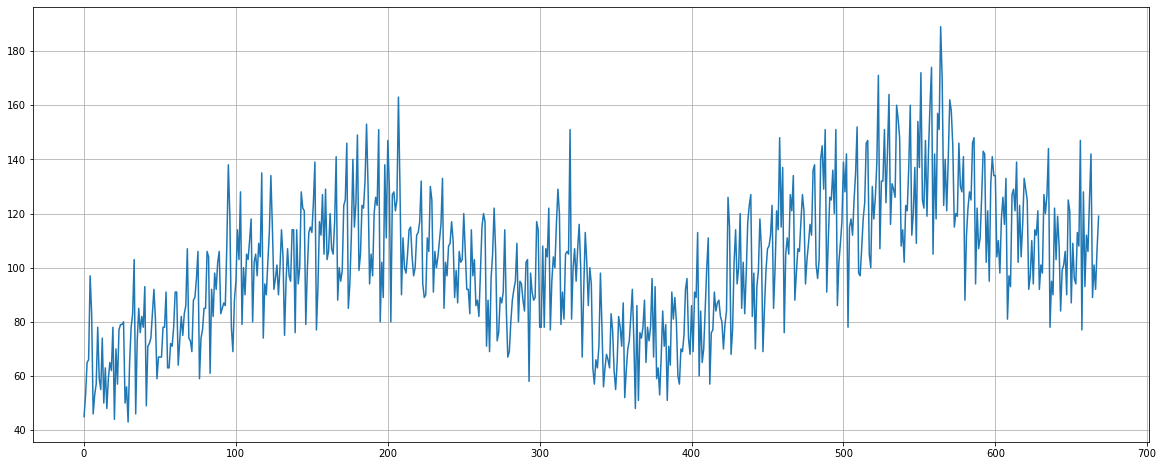

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

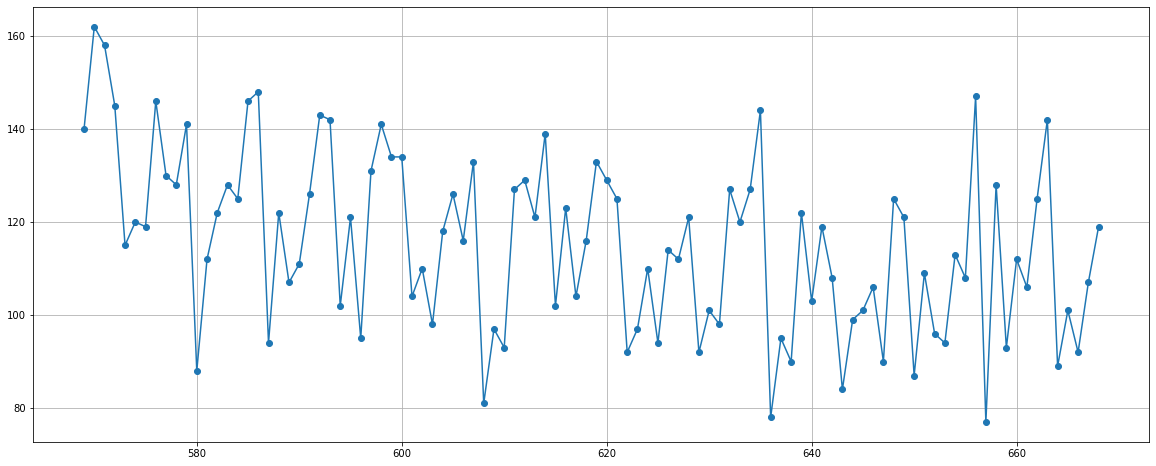

In [6]:
temp = data[-100:]
plt.figure(figsize = (20,8))
plt.plot(temp['sales'], marker ='o')
plt.grid()
plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 : 
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 1일 후의 수요량을 예측하려고 합니다.

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [7]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,sales,weekday,y
0,2013-01-01,45,Tue,53.0
1,2013-01-02,53,Wed,65.0
2,2013-01-03,65,Thu,66.0
3,2013-01-04,66,Fri,97.0
4,2013-01-05,97,Sat,83.0


,date,sales,weekday,y
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0
668,2014-10-31,119,Fri,NaN


In [8]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,sales,weekday,y
663,2014-10-26,142,Sun,89.0
664,2014-10-27,89,Mon,101.0
665,2014-10-28,101,Tue,92.0
666,2014-10-29,92,Wed,107.0
667,2014-10-30,107,Thu,119.0


## (2) 데이터 분할

### 1) x, y 나누기

In [9]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [10]:
# 여기서는 1회 분할로 진행합니다.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.모델링1 : ARIMA

## (1) y 값 살펴보기

* 정규성 검정(> 0.05) :  0.00853
* 정상성 검정(< 0.05) :  0.27897
* 자기상관성 확인(ACF, PACF)


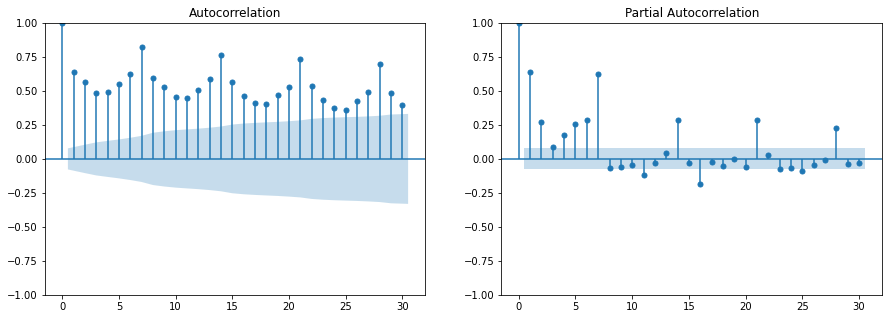

In [11]:
residual_diag(y_train, lags = 30)

## (2) 모델링 : 초기모델

* p, d, q 값을 어떻게 정해야 할까요?
* AR의 p 차수와 MA q 차수 모두 값이 필요해 보입니다. 일단 1, 1을 지정합시다.

### 1) 학습

* sm.tsa.SARIMAX(train, order=(p,d,q)).fit()
    * 모델 선언시 train이 포함
    * .fit()으로 학습.

In [12]:
# ARIMA 모델링
m1_1 = sm.tsa.SARIMAX(y_train, order=(1,0,1)).fit()
m1_2 = sm.tsa.SARIMAX(y_train, order=(1,1,1)).fit()

### 2) 평가

#### ① 잔차진단

* 모델.resid : 잔차를 뽑을 수 있습니다.
* 위에서 만든 함수 residual_diag 를 사용하여 잔차진단을 해 봅시다.

* 정규성 검정(> 0.05) :  0.38776
* 정상성 검정(< 0.05) :  0.00088
* 자기상관성 확인(ACF, PACF)


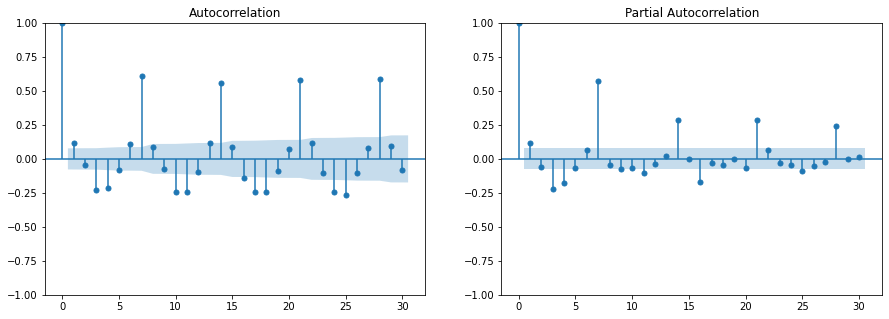

In [13]:
residuals = m1_1.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.07599
* 정상성 검정(< 0.05) :  0.00115
* 자기상관성 확인(ACF, PACF)


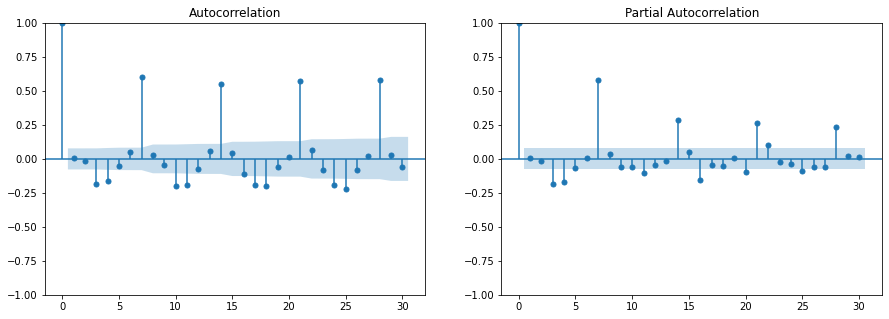

In [14]:
residuals = m1_2.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수
* SARIMAX 모델.aic로 쉽게 통계량을 구할 수 있습니다.

In [15]:
print('model1 AIC :', m1_1.aic)
print('model2 AIC :', m1_2.aic)

model1 AIC : 5464.670363961821
model2 AIC : 5442.769868773909


#### ③ Validation

시계열 데이터로 실제값과 예측값에 대해 비교하여 그래프를 그려봅시다.

In [16]:
pred = m1_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 12.918460972460833
MAPE: 0.12228691399082696


In [17]:
pred = m1_2.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 13.123421570527917
MAPE: 0.1253908412032481


* 결과 시각화

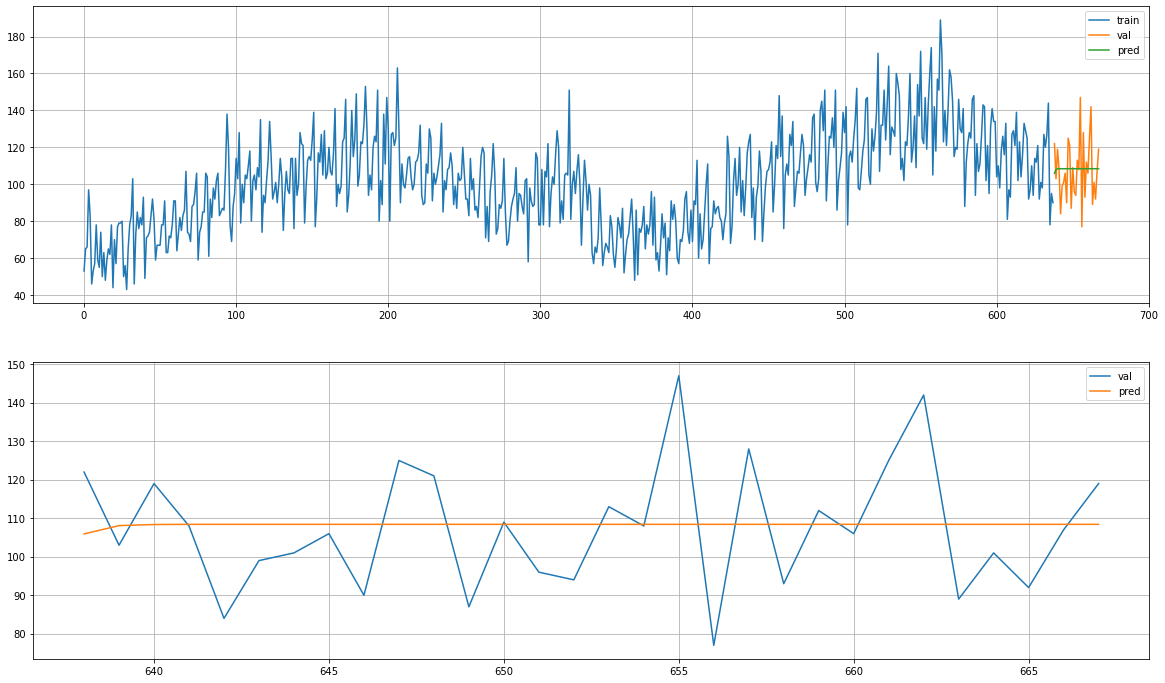

In [18]:
plot_model_result(y_train, y_val, pred)

## (3) 하이퍼파라미터 튜닝

실제로 p, d, q를 찾는 과정은 마치 Grid Search 처럼 값을 조금씩 조정해가며  최적의 모델을 찾아가는 과정과 유사합니다.


### 1) 학습

In [19]:
from itertools import product

* 값의 범위 지정

In [20]:
# product 함수를 이용하여 값의 조합을 구성
p = [1,2,3,4]
q = [1,2,3,4]
d = [1]
iter = list(product(p,d,q))
iter

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

* 튜닝

In [21]:
# 
mae, aic = [],[]
for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(i[0],i[1],i[2])).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)


In [22]:
result = pd.DataFrame({'params(p,d,q)' : iter, 'mae' : mae, 'aic':aic})

display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(p,d,q)",mae,aic
11,"(3, 1, 4)",11.060956,5219.999524


,"params(p,d,q)",mae,aic
15,"(4, 1, 4)",11.648985,5172.019842


In [23]:
m1_3 = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.00617
* 정상성 검정(< 0.05) :  3e-05
* 자기상관성 확인(ACF, PACF)


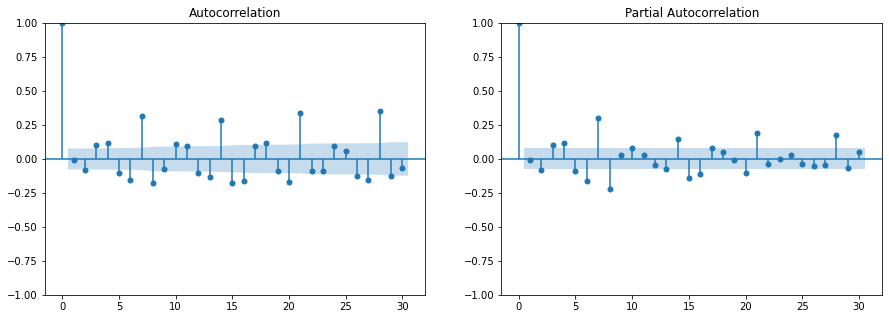

In [24]:
residuals = m1_3.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [25]:
print('model2 AIC :', m1_3.aic)

model2 AIC : 5172.019842062857


#### ③ Validation

In [26]:
pred = m1_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 11.648985016462868
MAPE: 0.11099016704992887


* 결과 시각화

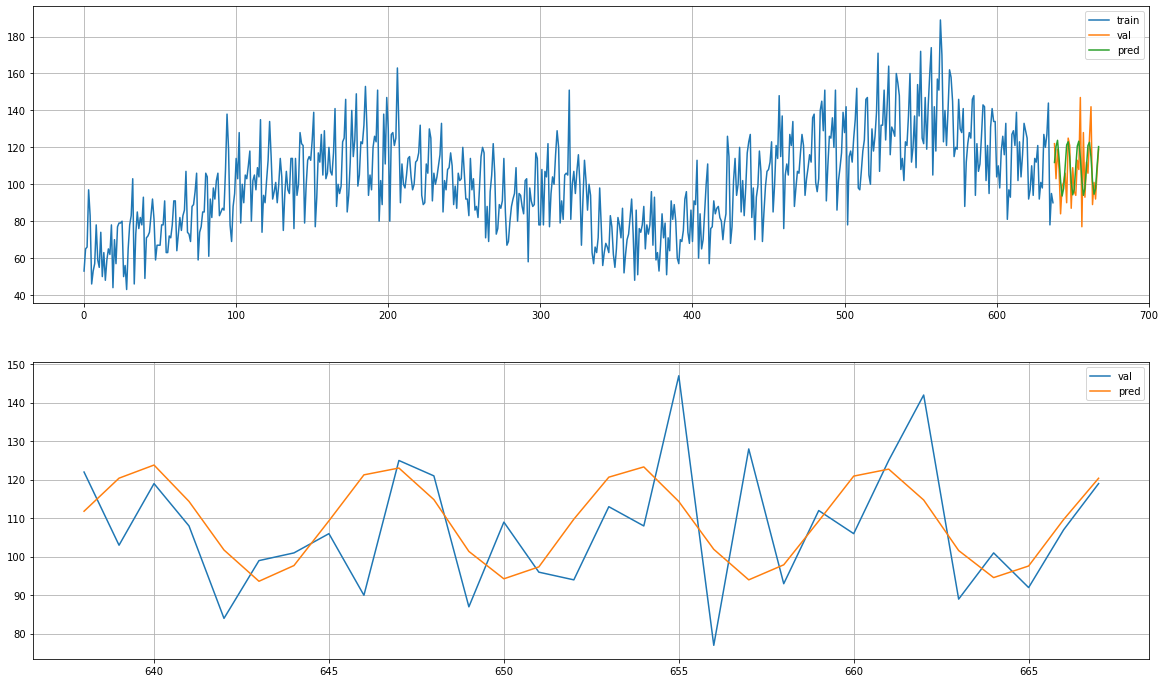

In [27]:
plot_model_result(y_train, y_val, pred)

# 4.모델링2 : SARIMA

## (1) 모델링 : 초기모델

### 1) 학습

In [28]:
# SARIMA 모델링
m2_1 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(1,1,1,7)).fit() # seasonal_order = (P,D,Q,m)

### 2) 평가

#### ① 잔차진단

* 정규성 검정(> 0.05) :  0.00161
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


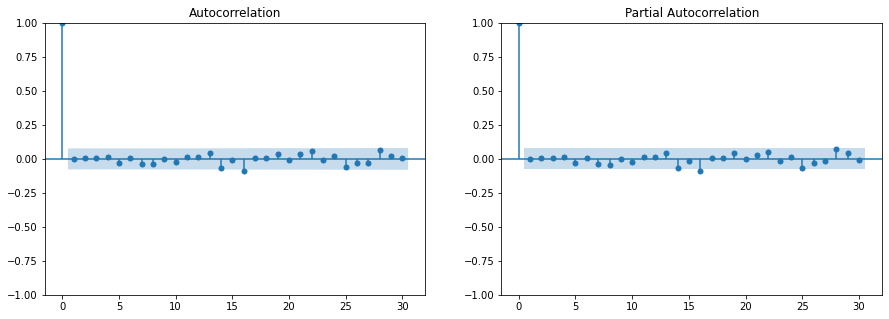

In [29]:
residuals = m2_1.resid
residual_diag(residuals)

#### ② AIC

In [30]:
print('model2_0 AIC :', m2_1.aic)

model2_0 AIC : 4846.6030517220515


#### ③ Validation

In [31]:
pred = m2_1.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 8.298972987248858
MAPE: 0.0764579269975612


* 결과 시각화

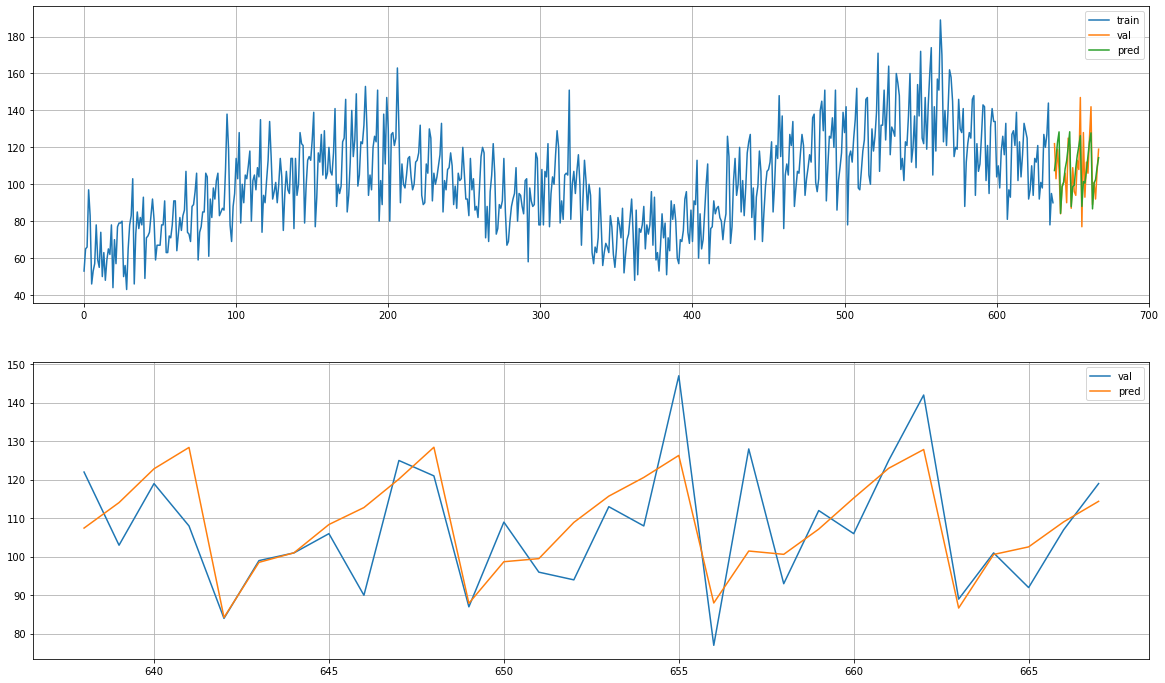

In [32]:
plot_model_result(y_train, y_val, pred)

## (2) 하이퍼파라미터 튜닝
2~4분 걸립니다. 돌려 놓고 쉬는시간 갖겠습니다.

### 1) 학습

In [33]:
P = [1,2,3,4,5]
Q = [1,2,3,4,5]
D = [1]
mae, aic = [],[]
iter = list(product(P,D,Q))

for i in iter :
    model_fit = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(i[0],i[1],i[2],7)).fit()
    pred = model_fit.forecast(30)
    mae.append( mean_absolute_error(y_val, pred))
    aic.append(model_fit.aic)
    print(i)

(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(1, 1, 4)
(1, 1, 5)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(2, 1, 4)
(2, 1, 5)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)
(3, 1, 4)
(3, 1, 5)
(4, 1, 1)
(4, 1, 2)
(4, 1, 3)
(4, 1, 4)
(4, 1, 5)
(5, 1, 1)
(5, 1, 2)
(5, 1, 3)
(5, 1, 4)
(5, 1, 5)


In [34]:
result = pd.DataFrame({'params(P,D,Q)' : iter, 'mae' : mae, 'aic':aic})

result

,"params(P,D,Q)",mae,aic
0,"(1, 1, 1)",8.298973,4846.603052
1,"(1, 1, 2)",8.371839,4847.160682
2,"(1, 1, 3)",8.379312,4848.678374
3,"(1, 1, 4)",8.311400,4850.922338
4,"(1, 1, 5)",8.264537,4851.342968
5,"(2, 1, 1)",8.388524,4846.603228
6,"(2, 1, 2)",8.259077,4850.770740
7,"(2, 1, 3)",8.383583,4853.531842
8,"(2, 1, 4)",8.474535,4853.510319
9,"(2, 1, 5)",8.675205,4850.962621


In [35]:
display(result.loc[result['mae'] == result.mae.min()])
display(result.loc[result['aic'] == result.aic.min()])

,"params(P,D,Q)",mae,aic
16,"(4, 1, 2)",8.172476,4850.983865


,"params(P,D,Q)",mae,aic
15,"(4, 1, 1)",8.337903,4843.617453


In [36]:
# MAE와 AIC 가 제일 낮은 값들로 모델을 각각 생성해 봅시다.
m2_2 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(4,1,2,7)).fit()
m2_3 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(  4,  1,  1, 7)).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

* 정규성 검정(> 0.05) :  0.00192
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


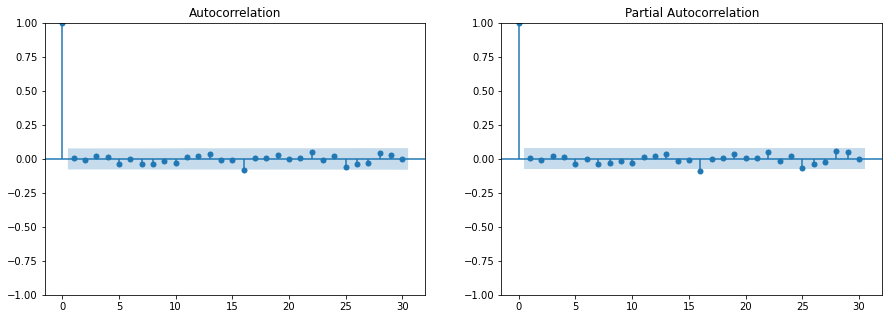

In [37]:
residuals = m2_2.resid
residual_diag(residuals)

* 정규성 검정(> 0.05) :  0.00241
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


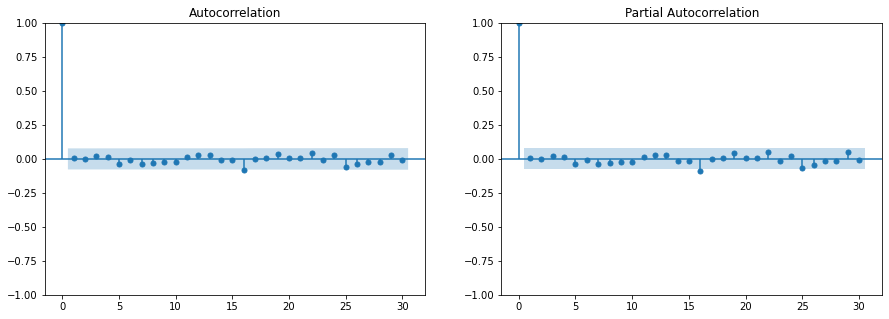

In [38]:
residuals = m2_3.resid
residual_diag(residuals)

#### ② AIC
* 선형 모델에서의 적합도와, feature가 과도하게 늘어나는 것을 방지하도록 설계된 통계량이 AIC 입니다.
* 값이 작을 수록 좋은 모델
* 공식 : 𝐴𝐼𝐶=−2 ln⁡(𝐿)+2𝑘 ➡ - 모델의 적합도 + 변수의 갯수

In [39]:
print('model2_2 AIC :', m2_2.aic)
print('model2_3 AIC :', m2_3.aic)

model2_2 AIC : 4850.98386490736
model2_3 AIC : 4843.617452640319


#### ③ Validation

In [40]:
pred = m2_3.forecast(30)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

MAE : 8.337903472669353
MAPE: 0.07727715550176938


* 결과 시각화

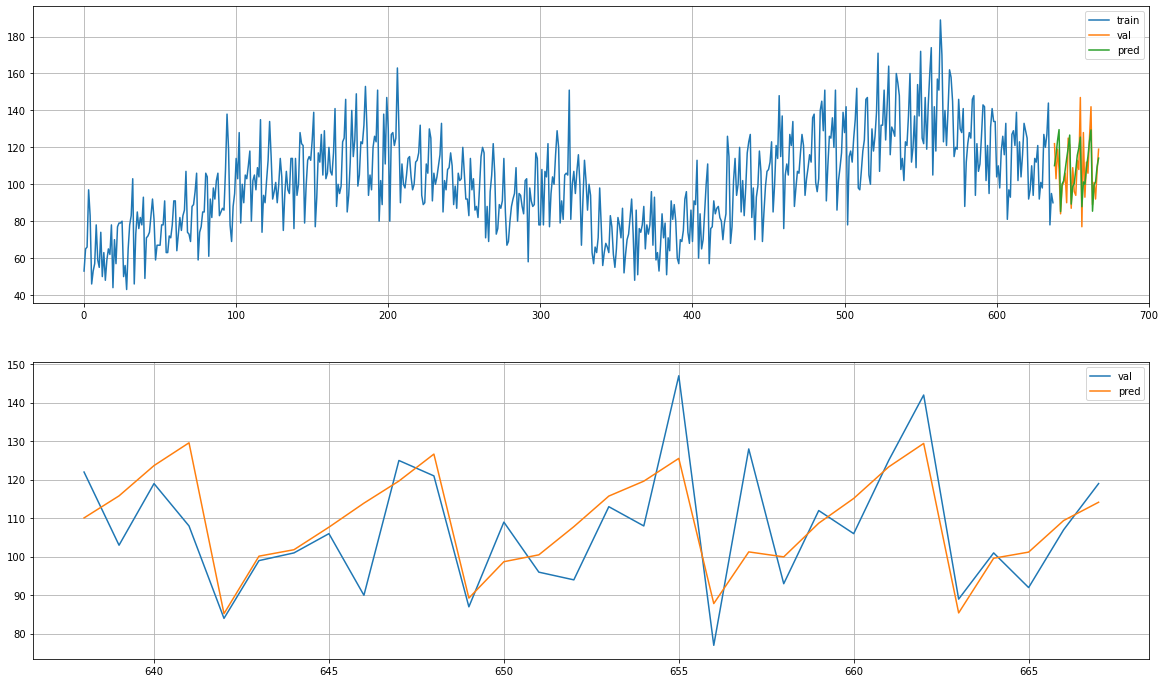

In [41]:
plot_model_result(y_train, y_val, pred)

# 5.모델링3 : SARIMAX

## (1) 전처리

In [42]:
# 가변수화
x2 = pd.get_dummies(x, columns = ['weekday'], drop_first=False)

# feature engineering
x2['sales_lag7'] = x2['sales'].shift(6)
x2.head(10)


,sales,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,sales_lag7
0,45,0,0,0,0,0,1,0,NaN
1,53,0,0,0,0,0,0,1,NaN
2,65,0,0,0,0,1,0,0,NaN
3,66,1,0,0,0,0,0,0,NaN
4,97,0,0,1,0,0,0,0,NaN
5,83,0,0,0,1,0,0,0,NaN
6,46,0,1,0,0,0,0,0,45.0
7,53,0,0,0,0,0,1,0,53.0
8,57,0,0,0,0,0,0,1,65.0
9,78,0,0,0,0,1,0,0,66.0


In [43]:
x3, y3 = x2[6:].copy(), y[6:].copy()

x3.reset_index(drop = True, inplace = True)
y3.reset_index(drop = True, inplace = True)
x3.head()

,sales,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,sales_lag7
0,46,0,1,0,0,0,0,0,45.0
1,53,0,0,0,0,0,1,0,53.0
2,57,0,0,0,0,0,0,1,65.0
3,78,0,0,0,0,1,0,0,66.0
4,59,1,0,0,0,0,0,0,97.0


In [44]:
x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 30, shuffle = False)

## (1) 모델링

### 1) 학습
* 학습할 때 **exog=x_train** 옵션이 포함되어야 함.

In [45]:
m3_1 = sm.tsa.SARIMAX(y_train, order=(4,1,4), seasonal_order=(1,1,1,7), exog=x_train).fit()

### 2) 평가

#### ① 잔차진단

* residual_diag

In [ ]:
residuals = m3_1.resid
residual_diag(residuals)

#### ② AIC

In [ ]:
print('m3_1 AIC :', m3_1.aic)

#### ③ Validation
SARIMAX 모델을 생성하고, 예측할 때는 **exog=x_val** 옵션이 들어가야 함.

In [ ]:
pred = m3_1.forecast(30,  exog=x_val)
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))

* 결과 시각화

In [ ]:
plot_model_result(y_train, y_val, pred)